# Generative Adversarial Network on MNIST database using Keras.

We start our project with importing all python tools needed. We also import MNIST database with 60000 images of handwritten digits.

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

/home/agnieszka/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

We will reshape our data, so the algorithm is easily adaptable to multichannel images, eg. RGB. We also scale it, so the input values are contained in [0,1] interval.

In [3]:
X_train = X_train.reshape(-1,28,28,1)
X_train = X_train.astype('float32')/255
data_num = X_train.shape[0]

Next step is creating discriminator. We define a function which takes as input list of numbers of filters in *Conv2D* layers, parameter *alpha* for _LeakyReLU_ layers, type of optimizer in compilation of the model, and dropout value. We use *strides* in *Conv2D* instead of *MaxPooling*. We choose filter shape to be (5,5) in every *Conv2D* layer.

In [4]:
def create_discriminator(filters, alpha, optimizer, dropout): 
    discriminator = Sequential()
    discriminator.add(Conv2D(filters[0], 5, strides=2, input_shape=X_train.shape[1:]))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    discriminator.add(Conv2D(filters[1], 5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    discriminator.add(Conv2D(filters[2], 5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    discriminator.add(Conv2D(filters[3], 5, strides=1, padding='same'))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return discriminator

Now we build generator model. To do this we define a function which takes as input:
* *dim* = $\frac{1}{4}$ of image side size. After two *UpSampling2D* layers we get image of shape $4*dim \times 4*dim$. 
* *depth*  - starting number of filters in convolutional layers. This is gradually reduced to 1 
* *input_dim* - size of one-dimensional noise vector
* *momentum* - parameter in BatchNotmalization layers
* *dropout* - dropout value

The function outputs a model that takes as input noise vector and outputs an image of shape $(4*dim, 4*dim,1)$

In [5]:
def create_generator(dim, depth, input_dim, momentum, dropout):
    generator = Sequential()
    
    generator.add(Dense(dim*dim*depth, input_dim=100))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))
    generator.add(Reshape((dim, dim, depth)))
    generator.add(Dropout(dropout))


    generator.add(UpSampling2D())
    generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))
    

    generator.add(UpSampling2D())
    generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))    

    generator.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(1, 5, padding='same'))
    generator.add(Activation('sigmoid'))
    return generator

After creating generator and discriminator, we are ready to join them together and build adversarial model. We will train adversarial after training disciminator, and we want to freeze parameters learned by discriminator, so that during adversarial training only parameters from generator part will be updated.

In [6]:
def create_adversarial(generator, discriminator, optimizer):
    adversarial = Sequential()
    adversarial.add(generator)
    adversarial.add(discriminator)
    adversarial.layers[1].trainable = False
    adversarial.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return adversarial

Let us define function which trains our GAN network. 

In [7]:
def train_GAN(epochs, batch_size, generator, adversarial):
    batches = int(data_num/batch_size)
    d_losses = []
    d_accuracies = []
    a_losses = []
    a_accuracies =[]
    for i in range(epochs):
        print("Epoch:",i)
        list_idx = list(range(data_num))
        np.random.shuffle(list_idx)
        list_idx = list_idx[:batch_size*batches]
        batches_idx=np.split(np.array(list_idx), batches)
        for j in range(batches):
            images_train = X_train[batches_idx[j]]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss, d_acc = discriminator.train_on_batch(x, y)
            d_losses.append(d_loss)
            d_accuracies.append(d_acc)
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss, a_acc = adversarial.train_on_batch(noise, y)
            a_losses.append(a_loss)
            d_accuracies.append(d_acc)
        
    return d_losses, d_accuracies, a_losses , a_accuracies

In [8]:
optimizer_d = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
optimizer_a = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)

In [9]:
discriminator = create_discriminator(filters =[64,128,256,512], alpha=0.2, optimizer=optimizer_d, dropout=0.4)
generator = create_generator(dim=7, depth=256, input_dim=100, momentum=0.9, dropout=0.4)
adversarial = create_adversarial(generator, discriminator, optimizer=optimizer_a)
d_losses, d_accuracies, a_losses , a_accuracies=\
                                    train_GAN(epochs=50, batch_size=256, generator=generator, adversarial=adversarial)

Epoch: 0


/home/agnieszka/.local/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


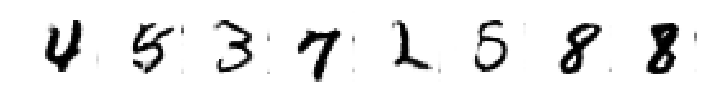

In [11]:
noise = np.random.uniform(-1.0, 1.0, size=[8, 100])
plt.figure(figsize=(12,4))
for i in range(1,9):
    plt.subplot(1, 8, i)
    plt.imshow(generator.predict(noise)[i-1][:,:,0], cmap = 'gray_r')
    plt.axis('off')
plt.show()

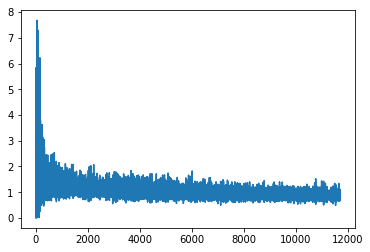

In [12]:
plt.plot(a_losses)

In [ ]:
plt.plot(d_losses)

In [ ]:
plt.plot(d_accuracies)